# Model 2: Hidden Markov Model + Viterbi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Data Preprocessing:


In [ ]:
# Load the training and test datasets
train_file_path = "/content/datatest.csv"
test_file_path = "/content/datatest.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Ensure the dataset has the required columns
required_columns = ["Temperature", "Humidity", "Light", "CO2", "Occupancy"]
if not all(col in train_df.columns for col in required_columns):
    raise ValueError("One or more required columns are missing from the dataset.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2665 non-null   int64  
 1   date           2665 non-null   object 
 2   Temperature    2665 non-null   float64
 3   Humidity       2665 non-null   float64
 4   Light          2665 non-null   float64
 5   CO2            2665 non-null   float64
 6   HumidityRatio  2665 non-null   float64
 7   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 166.7+ KB


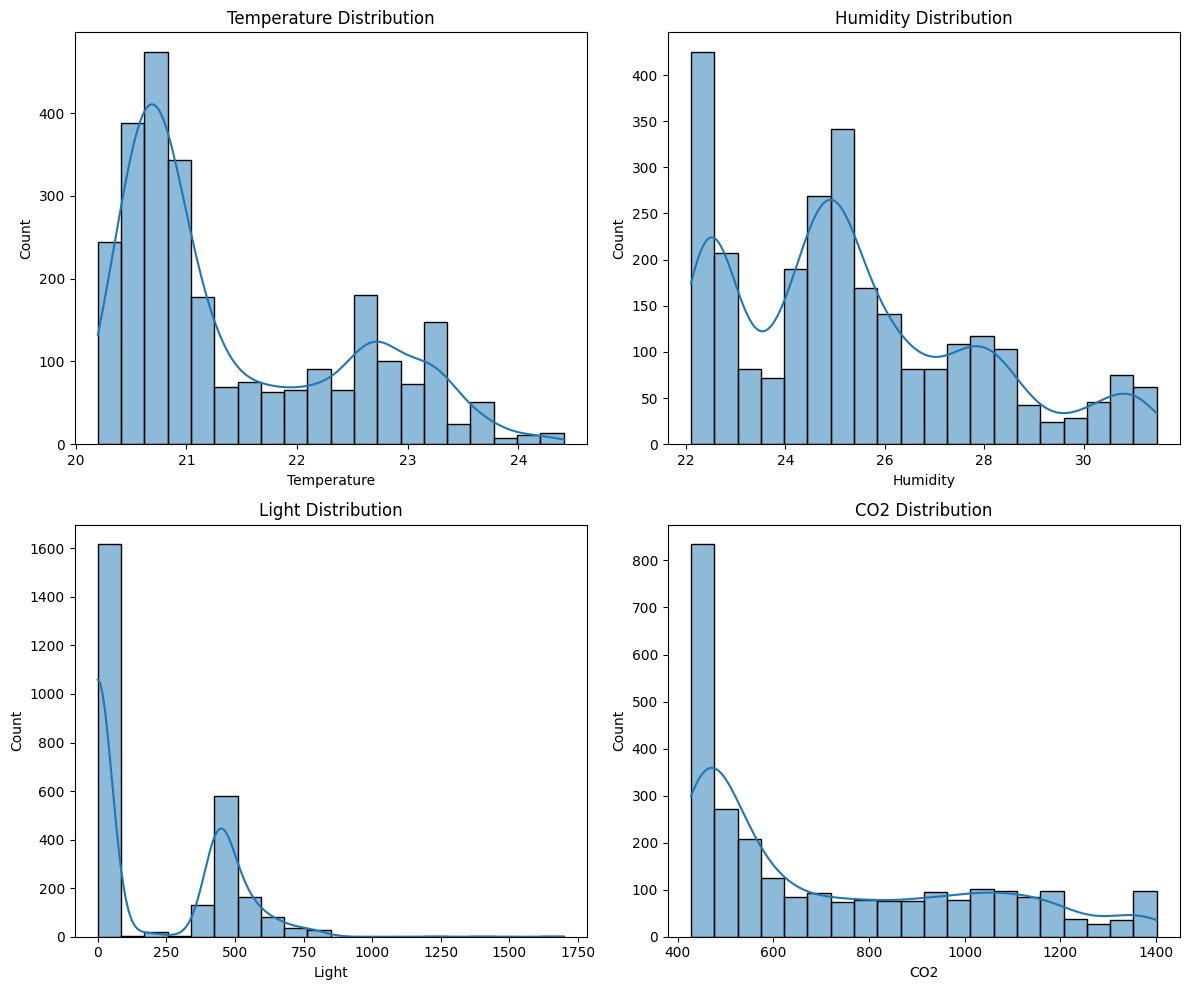

In [ ]:
# Display the first few rows to understand the dataset
train_df.head()

# Check dataset information (data types, missing values)
train_df.info()

# Summary statistics of numeric variables
train_df.describe()

# Visualizing the distribution of key variables
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(train_df['Temperature'], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Temperature Distribution')
sns.histplot(train_df['Humidity'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Humidity Distribution')
sns.histplot(train_df['Light'], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Light Distribution')
sns.histplot(train_df['CO2'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('CO2 Distribution')
plt.tight_layout()
plt.show()



In [ ]:
# Get basic information about the dataset
num_observations = train_df.shape[0]
num_columns = train_df.shape[1]
column_info = train_df.info()
missing_data = train_df.isnull().sum()
summary_statistics = train_df.describe()

print("\nObservations: ", num_observations)
print("\nNumber of Columns: ", num_columns)
print(column_info)
print(missing_data)
print(summary_statistics)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2665 non-null   int64  
 1   date           2665 non-null   object 
 2   Temperature    2665 non-null   float64
 3   Humidity       2665 non-null   float64
 4   Light          2665 non-null   float64
 5   CO2            2665 non-null   float64
 6   HumidityRatio  2665 non-null   float64
 7   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 166.7+ KB

Observations:  2665

Number of Columns:  8
None
id               0
date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64
                id  Temperature     Humidity        Light          CO2  \
count  2665.000000  2665.000000  2665.000000  2665.000000  2665.000000   
mean   1472.000000    21.433

### Generate CPTs:


In [ ]:

# Group feature values in increments of 0.5 for better accuracy
train_df["Temperature_group"] = (train_df["Temperature"] // 0.5) * 0.5
train_df["Humidity_group"] = (train_df["Humidity"] // 0.5) * 0.5
train_df["Light_group"] = (train_df["Light"] // 10) * 10  # Group Light values every 10 units
train_df["CO2_group"] = (train_df["CO2"] // 100) * 100  # Group CO2 values every 100 ppm

test_df["Temperature_group"] = (test_df["Temperature"] // 0.5) * 0.5
test_df["Humidity_group"] = (test_df["Humidity"] // 0.5) * 0.5
test_df["Light_group"] = (test_df["Light"] // 10) * 10  # Group Light values every 10 units
test_df["CO2_group"] = (test_df["CO2"] // 100) * 100  # Group CO2 values every 100 ppm

# Compute conditional probabilities by averaging for grouped values
cpt_grouped = {}

for feature in ["Temperature_group", "Humidity_group", "Light_group", "CO2_group", "HumidityRatio"]:
    # Calculate the probability of each Occupancy value for each grouped feature value
    cpt = train_df.groupby(feature)["Occupancy"].mean().to_frame()
    cpt["P(1)"] = cpt["Occupancy"]  # Probability of occupancy = 1
    cpt["P(0)"] = 1 - cpt["P(1)"]  # Probability of occupancy = 0
    cpt = cpt.drop(columns=["Occupancy"])  # Drop original column for clarity
    cpt_grouped[feature] = cpt

# Display the grouped CPTs using pandas
for feature, cpt in cpt_grouped.items():
    print(f"\nConditional Probability Table: P(Occupancy | {feature.replace('_group', '')})")
    display(cpt)










Conditional Probability Table: P(Occupancy | Temperature)


,P(1),P(0)
Temperature_group,,
20.0,0.062500,0.937500
20.5,0.106618,0.893382
21.0,0.236025,0.763975
21.5,0.463687,0.536313
22.0,0.620253,0.379747
22.5,0.934375,0.065625
23.0,0.872146,0.127854
23.5,1.000000,0.000000
24.0,1.000000,0.000000



Conditional Probability Table: P(Occupancy | Humidity)


,P(1),P(0)
Humidity_group,,
22.0,0.000000,1.000000
22.5,0.010067,0.989933
23.0,0.077922,0.922078
23.5,0.174419,0.825581
24.0,0.140704,0.859296
24.5,0.230539,0.769461
25.0,0.348837,0.651163
25.5,0.551724,0.448276
26.0,0.648855,0.351145



Conditional Probability Table: P(Occupancy | Light)


,P(1),P(0)
Light_group,,
0.0,0.000000,1.000000
50.0,0.000000,1.000000
160.0,0.000000,1.000000
170.0,0.000000,1.000000
180.0,0.000000,1.000000
190.0,0.000000,1.000000
210.0,1.000000,0.000000
260.0,0.000000,1.000000
310.0,1.000000,0.000000



Conditional Probability Table: P(Occupancy | CO2)


,P(1),P(0)
CO2_group,,
400.0,0.019038,0.980962
500.0,0.104167,0.895833
600.0,0.296296,0.703704
700.0,0.456250,0.543750
800.0,0.644578,0.355422
900.0,0.705202,0.294798
1000.0,0.901478,0.098522
1100.0,0.902703,0.097297
1200.0,0.972222,0.027778



Conditional Probability Table: P(Occupancy | HumidityRatio)


,P(1),P(0)
HumidityRatio,,
0.003303,0.0,1.0
0.003305,0.0,1.0
0.003305,0.0,1.0
0.003308,0.0,1.0
0.003308,0.0,1.0
...,...,...
0.005362,1.0,0.0
0.005364,1.0,0.0
0.005367,1.0,0.0


### Training setup:

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[['Temperature', 'Humidity', 'Light', 'CO2']])
test_features = scaler.transform(test_df[['Temperature', 'Humidity', 'Light', 'CO2']])


## Train the model:


In [ ]:
# Define Hidden Markov Model components
hidden_states = [0, 1]  # 0 = Unoccupied, 1 = Occupied
num_states = len(hidden_states)

# Compute Initial Probabilities P(state_0)
initial_prob = train_df['Occupancy'].value_counts(normalize=True).to_dict()

# Compute Transition Probabilities P(state_t | state_{t-1})
transition_matrix = np.zeros((num_states, num_states))
for prev, curr in zip(train_df['Occupancy'][:-1], train_df['Occupancy'][1:]):
    transition_matrix[prev, curr] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# Compute Emission Probabilities P(observation | state) using Gaussian distributions
from scipy.stats import norm
emission_probs = {}
for state in hidden_states:
    state_data = train_features[train_df['Occupancy'] == state]
    emission_probs[state] = {
        "mean": np.mean(state_data, axis=0),
        "std": np.std(state_data, axis=0) + 1e-6  # Avoid division by zero
    }

In [ ]:
def viterbi(observations, states, start_prob, trans_prob, emit_prob):
    num_obs = len(observations)
    num_states = len(states)
    log_prob = np.zeros((num_states, num_obs))
    backpointer = np.zeros((num_states, num_obs), dtype=int)

    # Initialization
    for s in states:
        log_prob[s, 0] = np.log(start_prob[s]) + np.sum(norm.logpdf(observations[0], emit_prob[s]['mean'], emit_prob[s]['std']))

    # Recursion
    for t in range(1, num_obs):
        for s in states:
            trans_probs = log_prob[:, t - 1] + np.log(trans_prob[:, s])
            best_prev_state = np.argmax(trans_probs)
            log_prob[s, t] = trans_probs[best_prev_state] + np.sum(norm.logpdf(observations[t], emit_prob[s]['mean'], emit_prob[s]['std']))
            backpointer[s, t] = best_prev_state

    # Termination
    best_final_state = np.argmax(log_prob[:, -1])
    best_path = [best_final_state]

    for t in range(num_obs - 1, 0, -1):
        best_final_state = backpointer[best_final_state, t]
        best_path.insert(0, best_final_state)

    return best_path

# Predict occupancy on the test set
predicted_states = viterbi(test_features, hidden_states, initial_prob, transition_matrix, emission_probs)

### Model Evaluation:


 HMM Model Accuracy: 0.9621

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1693
           1       0.91      1.00      0.95       972

    accuracy                           0.96      2665
   macro avg       0.95      0.97      0.96      2665
weighted avg       0.97      0.96      0.96      2665



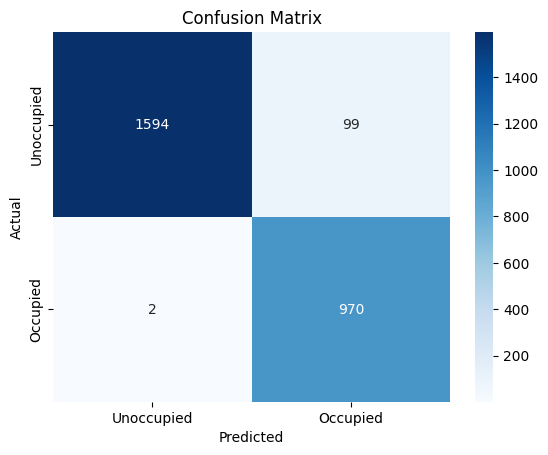

In [ ]:
accuracy = accuracy_score(test_df['Occupancy'], predicted_states)
print(f"\n HMM Model Accuracy: {accuracy:.4f}")

classification_rep = classification_report(test_df['Occupancy'], predicted_states)
print("\n Classification Report:\n", classification_rep)

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(test_df['Occupancy'], predicted_states)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Unoccupied', 'Occupied'], yticklabels=['Unoccupied', 'Occupied'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
